In [1]:
import pandas as pd
import geopandas as gpd
import pickle
import matplotlib.pyplot as plt
import hvplot as hv
import hvplot.pandas
import panel as pn
import sys,os
import numpy as np

import shap

project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))  # parent of notebooks
if project_root not in sys.path:
    sys.path.append(project_root)
    
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score,balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, root_mean_squared_error, mean_absolute_error, mean_squared_error


from src.util.model import eval_model, prep_data, plot_performance
seed = 42

In [2]:
dff0 = pd.read_csv("../../data/training_combined/training_combined.csv")
dff0['date'] = pd.to_datetime(dff0['date'])

danger_levels = pd.read_csv("../../../data/FAC/FAC_Danger_rating_zone_elv.csv")
danger_levels['date'] = pd.to_datetime(danger_levels['date'])

coords_geodf = gpd.read_file("../../../data/FAC/zones/grid_coords_subset.geojson")

zones_geodf = gpd.read_file("../../../data/FAC/zones/zone_coords.geojson")

exclude_cols = ['date','id_x','slope_azi', 'danger_level','altitude','slope_angle','elevation_band','lat', 'lon', 'zone_name', 'geometry']

X = dff0.loc[:, ~dff0.columns.isin(exclude_cols)].copy(deep=True)
y = dff0['danger_level']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed)

In [3]:
with open("../../data/models/best_model.pkl", "rb") as file:
    rf = pickle.load(file)

In [4]:
point_data = pd.concat([X,dff0[exclude_cols]],axis=1)
point_data['actual'] = y
point_data['predicted'] = rf.predict(X)

In [41]:
danger_colors={
    0:"green",
    1:"yellow",
    2:"orange",
    3:"red"
}

# Get the most frequent danger level across each zone, if there is a tie the higher value is picked
day_data = point_data[point_data['date'] == '2023-01-02'].groupby(by="zone_name")['danger_level'].agg(lambda x: x.mode().max()).reset_index()

print(day_data)

day_data['zone_name'] = day_data['zone_name'].replace({
    "swan":"Swan",
    "flathead":"Glacier/Flathead",
    "whitefish":"Whitefish"
})

zones_dangers = pd.merge(day_data, zones_geodf, on="zone_name", how='inner')
zones_dangers = gpd.GeoDataFrame(zones_dangers)

zones_dangers['color'] = zones_dangers['danger_level'].map(danger_colors)

a = point_data.hvplot.points(x='lon',y='lat',geo=True, tiles=True, c="black",s=10,hover_cols=['id'])
b = zones_dangers.hvplot.polygons(geo=True, tiles=True, c="color", alpha=0.6, tiles_opts={'alpha': 1}, responsive=True,hover_cols=['danger_level','zone_name'])

# b * a

   zone_name  danger_level
0   flathead             1
1       swan             1
2  whitefish             1


# Performance Plotting

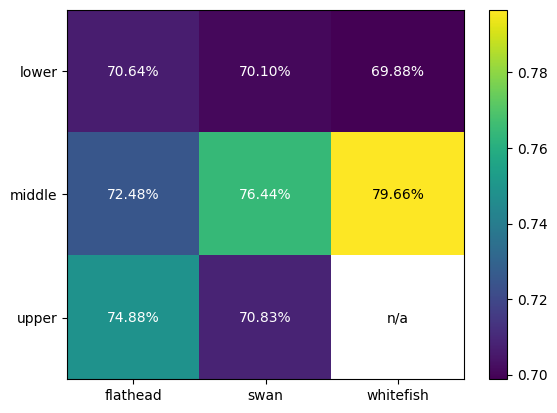

In [136]:
test_excluded = dff0.iloc[X_test.index]
test_excluded = test_excluded.loc[:,test_excluded.columns.isin(exclude_cols)]

test_data = pd.concat([X_test,test_excluded],axis=1)
test_data['actual'] = y_test
test_data['predicted'] = rf.predict(X_test)

plot_performance(test_data)

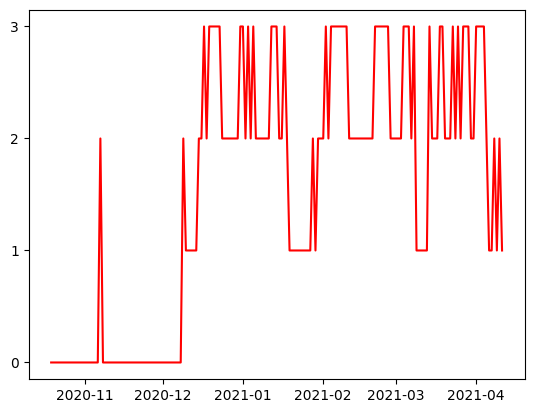

In [19]:
tdf = point_data[(point_data['id_x'] == 105) & (point_data['date'] < pd.Timestamp(year=2021,month=7,day=1))]
# tdf.hvplot.line(x='date',y='danger_level') * tdf.hvplot.line(x='date',y='predicted')
# tdf['diff'] = abs(tdf['danger_level'] - tdf['predicted'])
# plt.plot(tdf['date'], tdf['diff'])
plt.plot(tdf['date'], tdf['predicted'], color='red')
plt.yticks(ticks = [0,1,2,3])
plt.show()

# SHAP Visualization
explain expected value
how shap works

In [44]:
shap.initjs()

In [37]:
# explainer = shap.TreeExplainer(rf, feature_names=X.columns)

explainer = shap.KernelExplainer(rf.predict,shap.sample(X_train, 100, random_state=seed), feature_names=X_train.columns)

In [101]:
explanation = explainer(X_test.iloc[0:50])


  0%|          | 0/50 [00:00<?, ?it/s]

## Beeswarm plot
Designed to display an information-dense summary of how the top features in a dataset affect the models output
- By default the features are ordered by the mean absolute SHAP score, places a higher emphasis on broad average impact

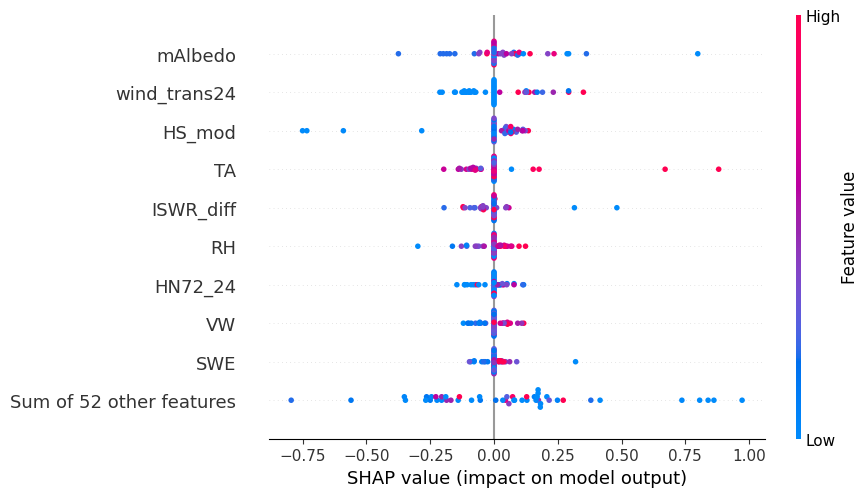

In [102]:
shap.plots.beeswarm(explanation, max_display=10)


## Heatmap Plot
Plots instances on the x-axis, model inputs on the y-axis, and the SHAP values encoded on a color scale. The samples are ordered based on clustering by their explanation similarity. This usually results in samples that have the same model output for the same reason getting grouped together. 

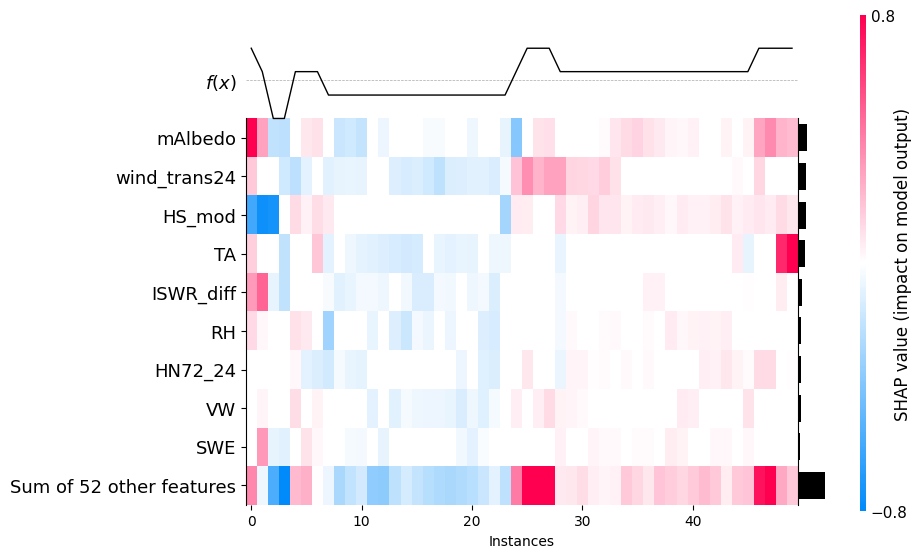

<Axes: xlabel='Instances'>

In [104]:
shap.plots.heatmap(explanation, max_display=10)

# Violin Plot
Offers a compact representation of the distribution and variability of SHAP values for each feature. 
- Stacked by importance of the feature on model output (Sum of abs of SHAP values per feature)
- Wider = higher density and more frequent values

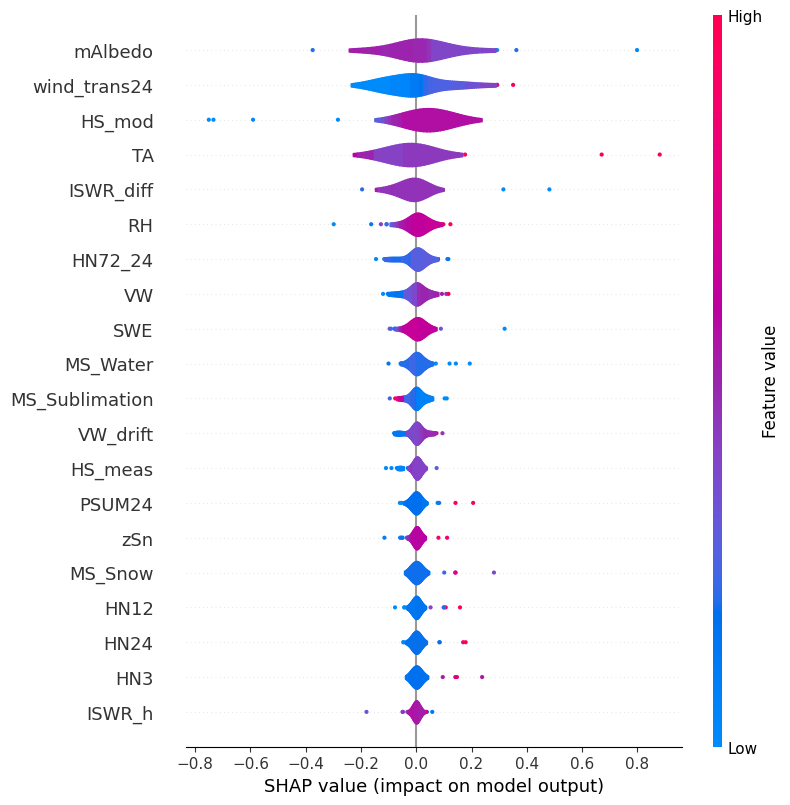

In [119]:
shap.plots.violin(explanation)


# Waterfall plot
Display explanations for individual predictions.
- Bottom of the waterfall starts at the expected value of the model output, and each row shows how + (red) or - (blue) the contribution of each feature moves the value from the expected model to the prediction.

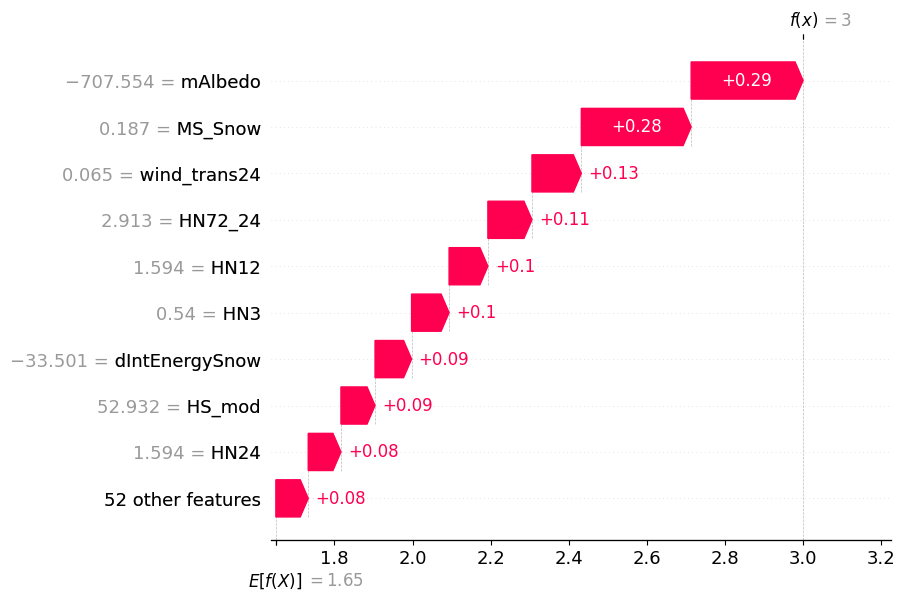

In [120]:
shap.waterfall_plot(shap_values=explanation[0])

## Scatter Plot
Shows the effect a single feature has on the predictions made by the model.
- Each dot is a single prediction
- x-axis is the value of the feature
- y-axis is the SHAP value

Can color by the explanation object to visualize relationships with other features

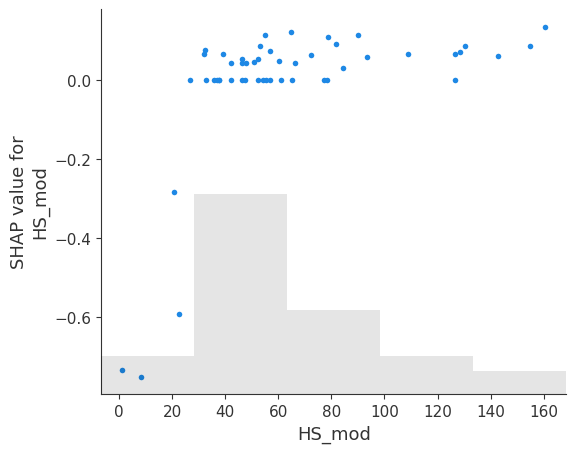

In [117]:
shap.plots.scatter(explanation[:, "HS_mod"]) #, color=explanation

We can use shap.approximate_interactions to guess which features may interact with age

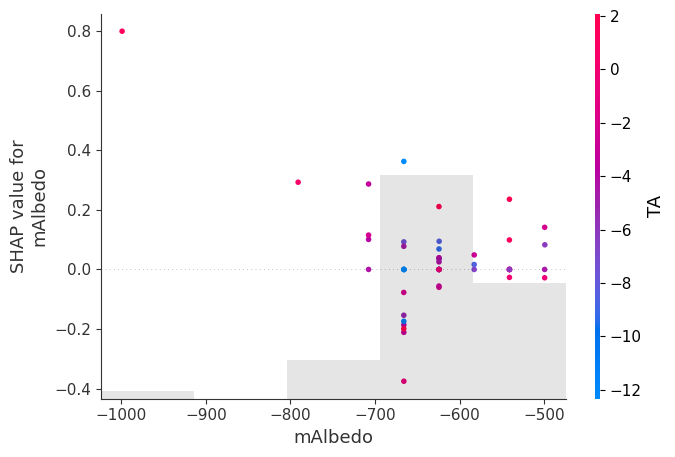

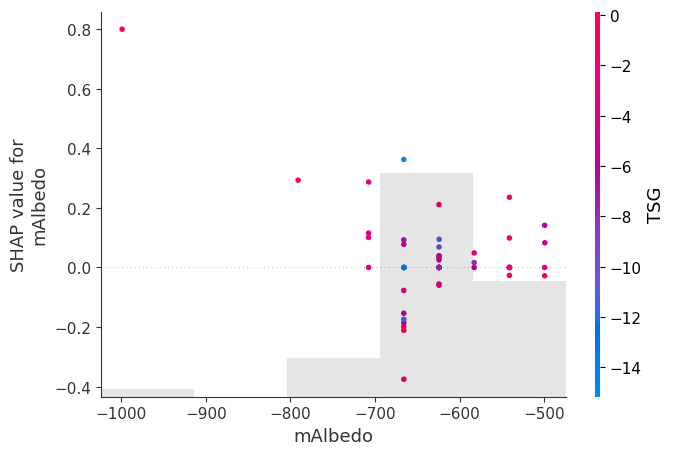

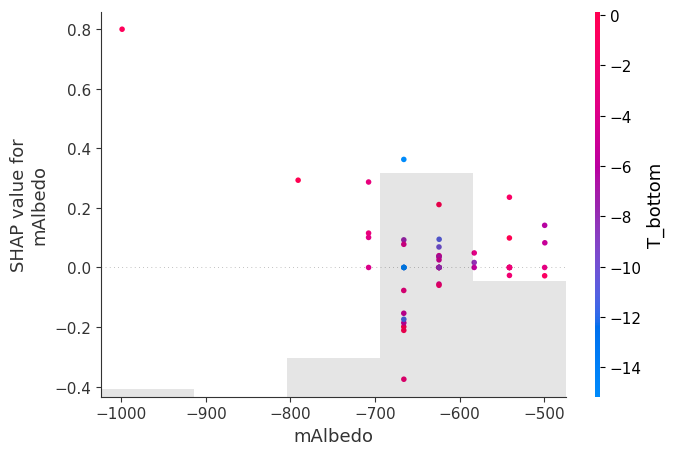

In [114]:
inds = shap.utils.potential_interactions(explanation[:, "mAlbedo"], explanation)

# make plots colored by each of the top three possible interacting features
for i in range(3):
    shap.plots.scatter(explanation[:, "mAlbedo"], color=explanation[:, inds[i]])